# Image Classification using CNN - Horizontal Flip, Zoom, Rotation & Random Crop

In this notebook, we perform classification of the MNIST Fashion dataset. We train the model with augmented data. We perform horizontal flip augmentation.


### CNN Architecture

We build a 4-hidden layer CNN model:
- 3 Convolutional layers and 1 Fully-Connected (dense) layer


### Regularization
To reduce overfitting, we use data augmentation based regularization. We perform:
- Horizontal flip
- Zoom
- Rotation
- Random Crop

Refer to the following notebook to learn how to use Keras' ImageDataGenerator class to perform data augmentation.
https://github.com/rhasanbd/Data-Augmentation/blob/main/Keras-Data%20Augmentation.ipynb


### Overcome Vanishing Gradient Problem
We use Batch Normalization to overcome the vanishing gradient problem.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

## Load & Preprocess Data

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()


# Split the training set into training & validation subsets
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]


# The data must be a 4D tensor: sample size, height, width, channels
# Add a single channel for the grayscale images (for RGB images this step is not required)
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_valid = X_valid.reshape((X_valid.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))


# Convert datatype to float32
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')


# Scale the data
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0


# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)


print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)


Shape of Training Samples:  (55000, 28, 28, 1)
Shape of Training Labels:  (55000, 10)

Shape of Validation Samples:  (5000, 28, 28, 1)
Shape of Validation Labels:  (5000, 10)

Shape of Testing Samples:  (10000, 28, 28, 1)
Shape of Testing Labels:  (10000, 10)

Data type:  float32
Label type:  float32


## Data Augmentation

We perform following data augmentation on the training data.
- Resize: add 4 pixels so that after random cropping image shape is back to 28 x 28
- Rotation
- Zoom
- Horizontal flip
- Random crop


## Function for Random Cropping & Generator

In [3]:
def random_crop(img, random_crop_size, number_of_channels):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == number_of_channels
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length, number_of_channels):
    '''
    It takes as input a Keras Image Generator object (Iterator) and generates random crops 
    from the image batches generated by the original iterator.
    '''
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, number_of_channels))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length), number_of_channels)
        yield (batch_crops, batch_y)

## Data Augmentation Generator

In [4]:
%%time

size_of_mini_batch = 128
crop_length = 28

'''
Augment training data
- Resize: add 4 pixels so that after random cropping image shape is back to 32 x 32
- Rotation
- Zoom
- Horizontal flip
'''
X_train_resize = tf.image.resize(X_train, [32, 32], method='nearest', preserve_aspect_ratio=True)

train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zoom_range=0.4,
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
    

train_datagen.fit(X_train_resize)
X_train_datagen = train_datagen.flow(x=X_train_resize, y=y_train, batch_size=size_of_mini_batch)


'''
Create a cropped data generator using the augmented iterator object
'''
X_train_cropped = crop_generator(X_train_datagen, crop_length, 1)


'''
Create an ImageDataGenerator object for the validation data.
However, validation data should not be augmented.
'''

validation_size_of_mini_batch = 100

valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)
X_valid_datagen = valid_datagen.flow(x=X_valid, y=y_valid, batch_size=validation_size_of_mini_batch)

CPU times: user 3.09 s, sys: 281 ms, total: 3.37 s
Wall time: 735 ms


## Create the CNN Model

We apply the batch normalization (BN) layer before activation. There is no need to use bias neurons in the Convolutional layers (set the use_bias to False). Because the Conv layer is followed by a BN layer that adds a bias. The BN "shift" parameter shifts the output of the layer (thus acts like a bias). 

In [5]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
initializer = 'he_normal'
activation_func = 'relu'


model = Sequential()
model.add(Conv2D(32, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False, 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Activation(activation_func))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation(activation_func))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation(activation_func))
model.add(Flatten())

model.add(Dense(128, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation(activation_func))
model.add(Dense(10, activation='softmax'))


'''
Compile the model
'''
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0

## Train the Model

In [6]:
%%time

no_of_epochs = 20
history = model.fit(X_train_cropped, 
                    steps_per_epoch=len(X_train) // size_of_mini_batch,
                    epochs=no_of_epochs, 
                    verbose=1,
                    validation_data=(X_valid_datagen),
                    validation_steps=len(X_valid) // validation_size_of_mini_batch)

Epoch 1/20
429/429 [==============================] - 41s 95ms/step - loss: 0.7283 - accuracy: 0.7316 - val_loss: 0.4490 - val_accuracy: 0.8410
Epoch 2/20
429/429 [==============================] - 45s 105ms/step - loss: 0.5516 - accuracy: 0.7938 - val_loss: 0.5416 - val_accuracy: 0.8021
Epoch 3/20
429/429 [==============================] - 42s 98ms/step - loss: 0.4945 - accuracy: 0.8140 - val_loss: 0.4666 - val_accuracy: 0.8362
Epoch 4/20
429/429 [==============================] - 40s 94ms/step - loss: 0.4697 - accuracy: 0.8230 - val_loss: 0.3597 - val_accuracy: 0.8692
Epoch 5/20
429/429 [==============================] - 40s 93ms/step - loss: 0.4431 - accuracy: 0.8343 - val_loss: 0.3685 - val_accuracy: 0.8633
Epoch 6/20
429/429 [==============================] - 40s 94ms/step - loss: 0.4257 - accuracy: 0.8400 - val_loss: 0.3593 - val_accuracy: 0.8690
Epoch 7/20
429/429 [==============================] - 40s 94ms/step - loss: 0.4121 - accuracy: 0.8455 - val_loss: 0.3842 - val_accuracy

## Evaluate the Model on Test Data

In [7]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("\nTest Accuracy: {:.3f}".format(test_accuracy))
print("Test Loss: {:.3f}".format(test_loss))

train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)

print("\nTrain Accuracy: {:.3f}".format(train_accuracy))
print("Train Loss: {:.3f}".format(train_loss))

# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted_highest_proba = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class

# get the label/index of the highest probability class
y_test_highest_proba = np.argmax(y_test, axis=1) 

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test_highest_proba, y_test_predicted_highest_proba))

Epochs:  20

Test Accuracy: 0.895
Test Loss: 0.285

Train Accuracy: 0.907
Train Loss: 0.251

Test Confusion Matrix:
[[855   2   9   9   4   0 111   0  10   0]
 [  0 983   2   8   2   0   2   0   3   0]
 [ 29   0 871   8  46   0  42   0   4   0]
 [ 66   6   8 817  13   0  87   0   3   0]
 [ 11   0  40  39 822   0  85   0   3   0]
 [  0   0   0   0   0 974   0  22   0   4]
 [109   1  76  16  77   0 709   0  12   0]
 [  0   0   0   0   0   9   0 964   0  27]
 [  0   0   0   3   0   1   1   1 993   1]
 [  0   0   0   0   0   4   0  33   1 962]]


## Plot Learning Curves

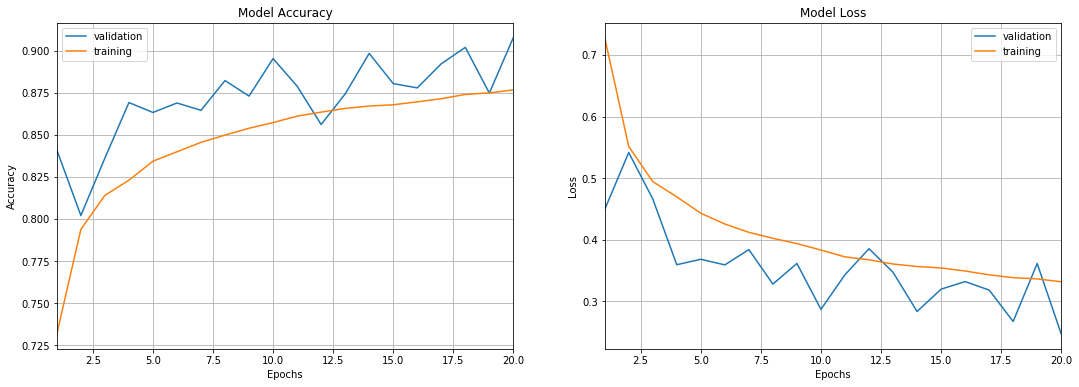

In [8]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show()